In [ ]:
# @title Default title text
import pandas as pd
import numpy as np

# ✅ Load the dataset
df = pd.read_csv("/content/d1_consistency.csv")


# ✅ Convert required columns to numeric (forcing errors='coerce' to handle bad data)
num_columns = [
    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Recent_Batting_Avg", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", "Recent_Bowling_Avg", "Catches_Taken",
    "Stumpings", "Credits", "Final_Consistency_Score"  # ✅ Added this
]

df[num_columns] = df[num_columns].apply(pd.to_numeric, errors="coerce")

# ✅ Fill NaN values with 0 (assuming missing stats mean 0 performance)
df.fillna(0, inplace=True)

# ✅ Fantasy points calculation
df["Fantasy_Points"] = (
    df["Runs_Scored"]  # Batting points
    + np.where(df["Runs_Scored"] >= 100, 16, 0)  # Century bonus
    + np.where((df["Runs_Scored"] >= 50) & (df["Runs_Scored"] < 100), 8, 0)  # Half-century bonus
    + np.where(df["Batting_Strike_Rate"] >= 140, 6,  # Strike rate bonus
               np.where(df["Batting_Strike_Rate"] >= 120, 4,
                        np.where(df["Batting_Strike_Rate"] >= 100, 2, 0)))
    - np.where((df["Runs_Scored"] == 0) & (df["Balls_Faced"] > 0), 2, 0)  # Duck penalty
    + df["Wickets_Taken"] * 25  # Bowling points
    + np.where(df["Four_Wicket_Hauls"] > 0, 8, 0)  # 4-wicket haul
    + np.where(df["Five_Wicket_Hauls"] > 0, 16, 0)  # 5-wicket haul
    + np.where(df["Economy_Rate"] < 5, 6,  # Economy rate bonus
               np.where(df["Economy_Rate"] < 6, 4,
                        np.where(df["Economy_Rate"] < 7, 2,
                                 np.where(df["Economy_Rate"] > 9, -2, 0))))
    + df["Catches_Taken"] * 8  # Fielding points
    + df["Stumpings"] * 12  # Stumping points
)

# ✅ Save updated dataset
df.to_csv("fantasy_ready_dataset.csv", index=False)
print("✅ Fantasy points calculated and saved in 'fantasy_ready_dataset.csv'!")

✅ Fantasy points calculated and saved in 'fantasy_ready_dataset.csv'!


In [ ]:
# @title Default title text
import pandas as pd

# Load your dataset (replace with your actual file path)
df = pd.read_csv("/content/fantasy_ready_dataset.csv")

# Show duplicates based on 'Player Name'
duplicate_players = df[df.duplicated(subset="Player_Name", keep=False)]
print("🔍 Duplicate entries found:\n", duplicate_players)

# ✅ Remove duplicates — keep only the first occurrence
df_unique = df.drop_duplicates(subset="Player_Name", keep="first")

# Save to a new file (optional)
df_unique.to_csv("CricMasters 2.0.csv", index=False)
print("✅ Duplicate player names removed. Cleaned dataset saved as 'unique_players.csv'")

🔍 Duplicate entries found:
            Player_Name  Credits Player Type Team  Matches_Batted   Not_Outs  \
18     Ruturaj Gaikwad      9.0         BAT  CHE       13.200000   1.600000   
19     Ruturaj Gaikwad      9.0         BAT  CHE       13.200000   1.600000   
29          Axar Patel      9.0         ALL   DC       13.636364   3.272727   
30          Axar Patel      9.0         ALL   DC       13.636364   3.272727   
55        Jayant Yadav      6.5        BOWL   GT        5.000000   0.500000   
56        Jayant Yadav      6.5        BOWL   GT        2.000000   0.000000   
62      Mahipal Lomror      6.5         BAT   GT        7.000000   1.200000   
63      Mahipal Lomror      6.5         BAT   GT        2.500000   0.000000   
75   Washington Sundar      7.0         ALL   GT        8.285714   1.714286   
76   Washington Sundar      7.0         ALL   GT        2.000000   1.000000   
115    Nicholas Pooran      8.5          WK  LSG       78.000000  18.000000   
116    Nicholas Pooran  

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pickle

# ✅ Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Gamethon/CricMasters_2.0.csv")

# ✅ Convert numerical columns to float
num_columns = [
    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", "Bat_Consistency","Catches_Taken",
    "Stumpings", "Credits", "Consistency_Score","Bowl_Consistency"
]
# ✅ Convert columns to numeric (forcing errors='coerce' to handle bad data)
df[num_columns] = df[num_columns].apply(pd.to_numeric, errors="coerce")

# ✅ Fill missing values with 0
df.fillna(0, inplace=True)

# ✅ Select Features and Target
features = [
    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", "Bat_Consistency","Catches_Taken",
    "Stumpings", "Credits", "Consistency_Score","Bowl_Consistency"
]

target = "Fantasy_Points"  # Ensure you've calculated Fantasy Points beforehand!

X = df[features]
y = df[target]

# ✅ Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Feature Scaling
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# ✅ Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

# Fit the grid search to find the best hyperparameters
grid_search.fit(X_train_scaled, y_train)

# ✅ Best Hyperparameters
print(f"Best parameters found: {grid_search.best_params_}")

# ✅ Train the model using the best hyperparameters from GridSearchCV
best_model = grid_search.best_estimator_

# ✅ Early Stopping
# Manually train the model with early stopping (GridSearchCV doesn't support early stopping)
best_model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], early_stopping_rounds=50, verbose=True)

# ✅ Make predictions
y_pred = best_model.predict(X_test_scaled)

# ✅ Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"✅ Improved Model MAE: {mae:.2f}")

# ✅ Save the trained model
with open("fantasy_model.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)

print("✅ Fantasy Model saved as 'fantasy_model.pkl'")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}


TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
# @title Default title text
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# ✅ Load the dataset
df= pd.read_csv("/content/drive/MyDrive/Gamethon/CricMasters_2.0.csv")

# ✅ Convert numerical columns to float
num_columns = [
    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", "Bat_Consistency","Catches_Taken",
    "Stumpings", "Credits", "Consistency_Score","Bowl_Consistency"]
# ✅ Convert columns to numeric (forcing errors='coerce' to handle bad data)
df[num_columns] = df[num_columns].apply(pd.to_numeric, errors="coerce")

# ✅ Fill missing values with 0
df.fillna(0, inplace=True)

# ✅ Select Features and Target

features = [

    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", "Bat_Consistency","Catches_Taken",
    "Stumpings", "Credits", "Consistency_Score","Bowl_Consistency"
]

target = "Fantasy_Points"  # Ensure you've calculated Fantasy Points beforehand!

X = df[features]
y = df[target]

# ✅ Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    enable_categorical=False  # Make sure categorical features are not included
)

xgb_model.fit(X_train, y_train)

# ✅ Make predictions
y_pred = xgb_model.predict(X_test)

# ✅ Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"✅ Model Training Completed! MAE: {mae:.2f}")

# ✅ Save the trained model
import pickle
with open("fantasy_model.pkl", "wb") as model_file:
    pickle.dump(xgb_model, model_file)

print("✅ Fantasy Model saved as 'fantasy_model.pkl'")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Gamethon/CricMasters_2.0.csv'

In [ ]:
# @title Default title text
import pandas as pd
import pickle
from google.colab import files

# 🔹 Ask user to upload the 'playing 22' CSV file
print("🔹 Please upload the 'playing 22' CSV file:")
uploaded = files.upload()

# ✅ Get uploaded filename
playing_22_csv = list(uploaded.keys())[0]
print(f"✅ File '{playing_22_csv}' uploaded successfully!")

# ✅ Load main player dataset
df_main = pd.read_csv("/content/drive/MyDrive/Gamethon/CricMasters -final.csv")
df_main.rename(columns={'Player Type': 'Player_Type'}, inplace=True)

# ✅ Load trained fantasy prediction model
model = pickle.load(open("/content/fantasy_model.pkl", "rb"))

# ✅ Define input features
num_columns = [
    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", "Bat_Consistency","Catches_Taken",
    "Stumpings", "Credits", "Consistency_Score","Bowl_Consistency"
]

# ✅ Role mapping
role_map = {
    "WICKETKEEPER": "WK",
    "BATTER": "BAT",
    "ALLROUNDER": "ALL",
    "BOWLER": "BOWL"
}

def select_best_11(playing_22_csv):
    df_playing_22 = pd.read_csv(playing_22_csv)
    df_playing_22 = df_playing_22[df_playing_22["IsPlaying"] == "PLAYING"]
    print(f"✅ Found {len(df_playing_22)} players marked as 'PLAYING'.")

    # Merge with main dataset
    match_players = df_playing_22.merge(df_main, left_on="Player Name", right_on="Player Name", how="left")

    if "Credits_x" in match_players.columns:
        match_players["Credits"] = match_players["Credits_x"]
    elif "Credits_y" in match_players.columns:
        match_players["Credits"] = match_players["Credits_y"]

    match_players = match_players.dropna(subset=["Credits"])

    # Clean up and map roles
    match_players["Player_Type"] = match_players["Player_Type"].str.upper().map(role_map).fillna(match_players["Player_Type"])
    print(f"✅ Found {len(match_players)} players in the main dataset.")

    # Numeric conversions
    for col in num_columns:
        match_players[col] = pd.to_numeric(match_players[col], errors='coerce').fillna(0)

    # Predict points
    match_players["Predicted_Fantasy_Points"] = model.predict(match_players[num_columns])
    match_players = match_players.sort_values(by=["Predicted_Fantasy_Points", "lineupOrder"], ascending=[False, True])
    match_players = match_players.drop_duplicates(subset="Player Name")

    # Step 1: Pick top players under 90 credits
    selected = []
    total_credits = 0
    for _, row in match_players.iterrows():
        if len(selected) == 10:
            break
        if total_credits + row["Credits"] <= 90:
            selected.append(row)
            total_credits += row["Credits"]

    selected_df = pd.DataFrame(selected)

    # Step 2: Ensure at least 1 WK
    if (selected_df["Player_Type"] == "WK").sum() == 0:
        print("⚠️ No WK found in selected 10. Adding a WK from remaining...")
        remaining = match_players[~match_players["Player Name"].isin(selected_df["Player Name"])]
        wk_candidates = remaining[remaining["Player_Type"] == "WK"]

        if not wk_candidates.empty:
            best_wk = wk_candidates.iloc[0]
            selected_df = pd.concat([selected_df, pd.DataFrame([best_wk])])
        else:
            print("❌ No WK found in remaining players!")
            return None

   # Step 3: Ensure at least 3 BATs
    num_bats = (selected_df["Player_Type"] == "BAT").sum()
    if num_bats < 3:
        print(f"⚠️ Only {num_bats} BAT(s) found. Adding BATs from remaining to reach 3...")
        remaining = match_players[~match_players["Player Name"].isin(selected_df["Player Name"])]
        bat_candidates = remaining[remaining["Player_Type"] == "BAT"]
        bat_candidates = bat_candidates.sort_values(by="Predicted_Fantasy_Points", ascending=False)

        for _, row in bat_candidates.iterrows():
            if num_bats >= 3:
                break
            if selected_df["Credits"].sum() + row["Credits"] <= 100:
                selected_df = pd.concat([selected_df, pd.DataFrame([row])])
                selected_df = selected_df.drop_duplicates(subset="Player Name")
                num_bats = (selected_df["Player_Type"] == "BAT").sum()


      # Step 4: Trim to 11 players, maintaining constraints
    selected_df = selected_df.drop_duplicates(subset="Player Name")

    # Prioritize removing BOWLERs to reduce size
    while len(selected_df) > 11:
        bowlers = selected_df[selected_df["Player_Type"] == "BOWL"]
        if not bowlers.empty:
            remove_idx = bowlers.sort_values(by=["Consistency_Score", "Credits"], ascending=[True, False]).index[0]
            selected_df = selected_df.drop(remove_idx)
        else:
            selected_df = selected_df.iloc[:-1]  # fallback if no BOWL to drop


    # Add players if less than 11
    if len(selected_df) < 11:
        remaining = match_players[~match_players["Player Name"].isin(selected_df["Player Name"])]
        for _, row in remaining.iterrows():
            if len(selected_df) == 11:
                break
            if selected_df["Credits"].sum() + row["Credits"] <= 100:
                selected_df = pd.concat([selected_df, pd.DataFrame([row])])
                selected_df = selected_df.drop_duplicates(subset="Player Name")

    if len(selected_df) != 11:
        print("❌ Unable to finalize 11 players within 100 credits.")
        return None

    # Assign Captain & Vice-Captain
    selected_df = selected_df.sort_values(by=[ "Consistency_Score","Predicted_Fantasy_Points"], ascending=[False, False]).reset_index(drop=True)
    selected_df["C/VC"] = "NA"
    selected_df.loc[0, "C/VC"] = "C"
    selected_df.loc[1, "C/VC"] = "VC"

    # Save final team
    output_cols = ["Player Name", "Player_Type", "Credits", "Predicted_Fantasy_Points", "Consistency_Score", "C/VC"]
    selected_df[output_cols].to_csv("selected_best_11.csv", index=False)
    print("✅ Final team saved to 'selected_best_11.csv'")

    return selected_df


# 🔁 Run the function and display team
best_11_team = select_best_11(playing_22_csv)

if best_11_team is not None:
    print("\n🔹 Selected Best 11 Players:")
    display_cols = ["Player Name", "Credits", "Player_Type", "Consistency_Score", "C/VC"]
    print(best_11_team[display_cols].to_string(index=False))

    # 🔽 Download final team CSV
    #files.download("selected_best_11.csv")

🔹 Please upload the 'playing 22' CSV file:


Saving SquadPlayerNames_IndianT20League - Match_25.csv to SquadPlayerNames_IndianT20League - Match_25 (1).csv
✅ File 'SquadPlayerNames_IndianT20League - Match_25 (1).csv' uploaded successfully!
✅ Found 22 players marked as 'PLAYING'.
✅ Found 22 players in the main dataset.
⚠️ Only 1 BAT(s) found. Adding BATs from remaining to reach 3...
✅ Final team saved to 'selected_best_11.csv'

🔹 Selected Best 11 Players:
    Player Name  Credits Player_Type  Consistency_Score C/VC
     Noor Ahmad      8.5        BOWL         139.410000    C
  Khaleel Ahmed      8.0        BOWL         137.750000   VC
   Sunil Narine      9.0         ALL         103.155000   NA
Ravindra Jadeja      8.5         ALL          97.202500   NA
 Venkatesh Iyer      8.0         BAT          91.275000   NA
  Andre Russell      8.0         ALL          90.824167   NA
Quinton de Kock      8.0          WK           0.000000   NA
      Moeen Ali      7.0         ALL           0.000000   NA
   Devon Conway      7.5          WK  

In [ ]:
import pandas as pd

# Load the Excel file
file_path = "/content/drive/MyDrive/Gamethon/STADIUM.csv"  # Change path if needed
df = pd.read_csv(file_path)

# Extract and print column names
columns = df.columns.tolist()
print("Columns in the file:")
for col in columns:
    print(col)


In [ ]:
!pip install --upgrade xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.2 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [ ]:
import xgboost
print(xgboost.__version__)

2.1.4


In [ ]:
# prompt: install import lightgbm as lgb
# from catboost import CatBoostRegressor

!pip install lightgbm catboost




In [ ]:
!pip install --upgrade catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 97.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip install numpy==2.0.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 31.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.0.2 which is incompatible.


In [ ]:
# @title Default title text

# ✅ Import all necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb


# ✅ Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Gamethon/CricMasters_2.0.csv")

# ✅ Convert numerical columns to float
num_columns = [
    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", "Bat_Consistency","Catches_Taken",
    "Stumpings", "Credits", "Consistency_Score","Bowl_Consistency"]

df[num_columns] = df[num_columns].apply(pd.to_numeric, errors="coerce")
df.fillna(0, inplace=True)

# ✅ Select Features and Target
features = [

    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", "Bat_Consistency","Catches_Taken",
    "Stumpings", "Credits",
]

target = "Fantasy_Points"

X = df[features]
y = df[target]

# ✅ Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Define base learners
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
import xgboost as xgb
import lightgbm as lgb

xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
lgb_model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)

stack_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model)
    ],
    final_estimator=Ridge(),
    passthrough=True,
    cv=5
)


# ✅ Train the stacked model
stack_model.fit(X_train, y_train)

# ✅ Make predictions
y_pred_stack = stack_model.predict(X_test)

# ✅ Evaluate the model
mae_stack = mean_absolute_error(y_test, y_pred_stack)
print(f"✅ Stacked Model Training Completed! MAE: {mae_stack:.2f}")

# ✅ Save the stacked model
with open("stacked_fantasy_model.pkl", "wb") as model_file:
    pickle.dump(stack_model, model_file)

print("✅ Stacked Fantasy Model saved as 'stacked_fantasy_model.pkl'")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 596
[LightGBM] [Info] Number of data points in the train set: 182, number of used features: 19
[LightGBM] [Info] Start training from score 705.622059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [ ]:
# ✅ Import Libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
import lightgbm as lgb

# ✅ Load Dataset
df = pd.read_csv("/content/drive/MyDrive/Gamethon/CricMasters_2.0.csv")

# ✅ Convert numerical columns to float
num_columns = [
    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", "Bat_Consistency", "Catches_Taken",
    "Stumpings", "Credits", "Consistency_Score", "Bowl_Consistency"
]
df[num_columns] = df[num_columns].apply(pd.to_numeric, errors="coerce")
df.fillna(0, inplace=True)

# ✅ Outlier Removal (based on Fantasy Points)
q_low = df["Fantasy_Points"].quantile(0.01)
q_high = df["Fantasy_Points"].quantile(0.99)
df = df[(df["Fantasy_Points"] >= q_low) & (df["Fantasy_Points"] <= q_high)]


# ✅ Feature Selection
features = [
    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled", "Wickets_Taken", "Bowling_Average",
    "Economy_Rate", "Bowling_Strike_Rate", "Four_Wicket_Hauls", "Five_Wicket_Hauls",
    "Bat_Consistency", "Catches_Taken", "Stumpings", "Credits", "Consistency_Score",
    "Bowl_Consistency"
]
target = "Fantasy_Points"

X = df[features]
y = df[target]

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Define Models (with better hyperparameters)
xgb_model = xgb.XGBRegressor(n_estimators=700, learning_rate=0.03, max_depth=8, random_state=42)
lgb_model = lgb.LGBMRegressor(n_estimators=700, learning_rate=0.03, max_depth=8, random_state=42)

# ✅ Stacking Regressor
stack_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model)
    ],
    final_estimator=Ridge(),
    passthrough=True,
    cv=5
)

# ✅ Train the stacked model
stack_model.fit(X_train, y_train)

# ✅ Predict and Evaluate
y_pred_stack = stack_model.predict(X_test)
mae_stack = mean_absolute_error(y_test, y_pred_stack)
print(f"✅ Stacked Model Training Completed! MAE: {mae_stack:.2f}")

# ✅ Save model
with open("stacked_fantasy_model1.pkl", "wb") as model_file:
    pickle.dump(stack_model, model_file)

print("✅ Stacked Fantasy Model saved as 'stacked_fantasy_model1.pkl'")




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 177, number of used features: 18
[LightGBM] [Info] Start training from score 676.688771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
# @title Default title text
# 📦 Imports
import pandas as pd
import re
import pickle
from google.colab import files

# 📤 Upload 'playing 22' CSV
print("🔹 Please upload the 'playing 22' CSV file:")
uploaded = files.upload()
playing_22_csv = list(uploaded.keys())[0]
print(f"✅ File '{playing_22_csv}' uploaded successfully!")

# 🔍 Extract Match Number
match_no_match = re.search(r"Match[_\-](\d+)", playing_22_csv)
if match_no_match:
    match_no = int(match_no_match.group(1))
    print(f"🔍 Extracted Match Number: {match_no}")
else:
    print("❌ Could not extract match number from filename.")
    match_no = None

# 📄 Load Datasets and Model
df_main = pd.read_csv("/content/drive/MyDrive/Gamethon/CricMasters_2.0.csv")
df_main.rename(columns={'Player Type': 'Player_Type'}, inplace=True)
model = pickle.load(open("/content/stacked_fantasy_model.pkl", "rb"))
stadium_df = pd.read_csv("/content/drive/MyDrive/Gamethon/stadium_data.csv")

# 🏟️ Get pitch behavior
pitch_type = "Balanced"
if match_no is not None and match_no in stadium_df["match_no"].values:
    pitch_type = stadium_df[stadium_df["match_no"] == match_no]["Best_for"].values[0]
    print(f"🏟️ Pitch Behavior for Match {match_no}: {pitch_type}")
else:
    print("⚠️ No pitch behavior data found for this match.")

# 📊 Numeric Columns and Role Map
num_columns = [

    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", "Bat_Consistency","Catches_Taken",
    "Stumpings", "Credits", "Consistency_Score","Bowl_Consistency"
]

role_map = {
    "WICKETKEEPER": "WK", "BATTER": "BAT",
    "ALLROUNDER": "ALL", "BOWLER": "BOWL"
}

# 🎯 Best 11 Selector Function
def select_best_11_with_pitch_bonus():
    df_playing_22 = pd.read_csv(playing_22_csv)
    df_playing_22 = df_playing_22[df_playing_22["IsPlaying"] == "PLAYING"]

    match_players = df_playing_22.merge(df_main, on="Player Name", how="left")

    match_players["Credits"] = match_players.get("Credits_x", match_players.get("Credits_y", 0))
    match_players["Player_Type"] = match_players["Player_Type"].str.upper().map(role_map).fillna(match_players["Player_Type"])

    for col in num_columns:
        match_players[col] = pd.to_numeric(match_players[col], errors='coerce').fillna(0)

    # 🔮 Predict Fantasy Points
    match_players["Predicted_Fantasy_Points"] = model.predict(match_players[num_columns])

    # 💠 Apply Pitch Bonus
    if pitch_type == "Bowling":
        match_players.loc[match_players["Player_Type"].isin(["BOWL", "ALL"]), "Predicted_Fantasy_Points"] *= 1.05
    elif pitch_type == "Batting":
        match_players.loc[match_players["Player_Type"].isin(["BAT", "ALL", "WK"]), "Predicted_Fantasy_Points"] *= 1.05
    else:
        match_players["Predicted_Fantasy_Points"] *= 1.02

    match_players = match_players.sort_values(by=["Predicted_Fantasy_Points", "Consistency_Score", "lineupOrder"], ascending=[False, False, True])
    match_players = match_players.drop_duplicates(subset="Player Name")

    # 🧮 Select under 90 credits
    selected, total_credits = [], 0
    for _, row in match_players.iterrows():
        if len(selected) == 10: break
        if total_credits + row["Credits"] <= 90:
            selected.append(row)
            total_credits += row["Credits"]
    selected_df = pd.DataFrame(selected)

    # ✅ Ensure 1 WK
    if (selected_df["Player_Type"] == "WK").sum() == 0:
        wk = match_players[~match_players["Player Name"].isin(selected_df["Player Name"])]
        wk = wk[wk["Player_Type"] == "WK"]
        if not wk.empty:
            selected_df = pd.concat([selected_df, pd.DataFrame([wk.iloc[0]])])

    # ✅ Ensure at least 3 BAT
    while (selected_df["Player_Type"] == "BAT").sum() < 3:
        bats = match_players[~match_players["Player Name"].isin(selected_df["Player Name"])]
        bats = bats[bats["Player_Type"] == "BAT"]
        if not bats.empty:
            selected_df = pd.concat([selected_df, pd.DataFrame([bats.iloc[0]])])

    # ✅ Ensure at least 1 ALL
    if (selected_df["Player_Type"] == "ALL").sum() < 1:
        alls = match_players[~match_players["Player Name"].isin(selected_df["Player Name"])]
        alls = alls[alls["Player_Type"] == "ALL"]
        if not alls.empty:
            selected_df = pd.concat([selected_df, pd.DataFrame([alls.iloc[0]])])

    # ✅ Ensure at least 3 BOWL
    while (selected_df["Player_Type"] == "BOWL").sum() < 3:
        bowls = match_players[~match_players["Player Name"].isin(selected_df["Player Name"])]
        bowls = bowls[bowls["Player_Type"] == "BOWL"]
        if not bowls.empty:
            selected_df = pd.concat([selected_df, pd.DataFrame([bowls.iloc[0]])])

    # 🎖️ Assign Captain and Vice Captain
    selected_df = selected_df.sort_values(by="Consistency_Score", ascending=False).reset_index(drop=True)
    selected_df.loc[0, "Role"] = "Captain"
    selected_df.loc[1, "Role"] = "Vice-Captain"

    # 💾 Save final team
    output_filename = f"selected_best_11_match_{match_no}.csv"
    selected_df.to_csv(output_filename, index=False)
    print(f"✅ Final team saved to: {output_filename}")

    return selected_df

# 🚀 Run selection
final_team = select_best_11_with_pitch_bonus()
final_team[["Player Name", "Player_Type", "Credits", "Predicted_Fantasy_Points", "Role"]].head(11)

🔹 Please upload the 'playing 22' CSV file:


Saving SquadPlayerNames_IndianT20League - Match_26.csv to SquadPlayerNames_IndianT20League - Match_26 (2).csv
✅ File 'SquadPlayerNames_IndianT20League - Match_26 (2).csv' uploaded successfully!
🔍 Extracted Match Number: 26
🏟️ Pitch Behavior for Match 26: Bowling
✅ Final team saved to: selected_best_11_match_26.csv


,Player Name,Player_Type,Credits,Predicted_Fantasy_Points,Role
0,Nicholas Pooran,WK,9.0,2232.041231,Captain
1,Mohammed Siraj,BOWL,8.5,2858.161629,Vice-Captain
2,Rashid-Khan,BOWL,8.0,4843.589093,NaN
3,Sai Sudharsan,BAT,8.5,1285.109870,NaN
4,Shubman Gill,BAT,9.0,601.291685,NaN
5,Jos Buttler,WK,9.0,3990.119951,NaN
6,David Miller,BAT,7.5,3548.673220,NaN
7,Arshad Khan,ALL,6.5,4847.441114,NaN
8,Aiden Markram,ALL,8.0,1366.089609,NaN
9,Himmat Singh,BAT,5.5,1366.030123,NaN


In [ ]:
# @title Default title text
import pandas as pd
import pickle
import re
from google.colab import files

# Upload 'playing 22' CSV file
print("🔹 Please upload the 'playing 22' CSV file:")
uploaded = files.upload()
playing_22_csv = list(uploaded.keys())[0]
print(f"✅ File '{playing_22_csv}' uploaded successfully!")

# Load datasets and model
df_main = pd.read_csv("/content/drive/MyDrive/Gamethon/CricMasters -final.csv")
df_main.rename(columns={'Player Type': 'Player_Type'}, inplace=True)

stadium_df = pd.read_csv("/content/drive/MyDrive/Gamethon/stadium_data.csv")  # your stadium dataset
model = pickle.load(open("/content/fantasy_model.pkl", "rb"))

num_columns = [


    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", "Bat_Consistency","Catches_Taken",
    "Stumpings", "Credits", "Consistency_Score","Bowl_Consistency"
]

role_map = {
    "WICKETKEEPER": "WK",
    "BATTER": "BAT",
    "ALLROUNDER": "ALL",
    "BOWLER": "BOWL"
}

def extract_match_no(filename):
    match = re.search(r'Match[_\-](\d+)', filename)
    return int(match.group(1)) if match else None

def select_best_11(playing_22_csv):
    match_no = extract_match_no(playing_22_csv)
    if match_no is None:
        print("❌ Match number not found in filename.")
        return

    df_playing_22 = pd.read_csv(playing_22_csv)
    df_playing_22 = df_playing_22[df_playing_22["IsPlaying"] == "PLAYING"]
    print(f"✅ Found {len(df_playing_22)} players marked as 'PLAYING'.")

    match_players = df_playing_22.merge(df_main, left_on="Player Name", right_on="Player_Name", how="left")
    match_players["Credits"] = match_players["Credits_x"] if "Credits_x" in match_players else match_players["Credits_y"]
    match_players = match_players.dropna(subset=["Credits"])
    match_players["Player_Type"] = match_players["Player_Type"].str.upper().map(role_map).fillna(match_players["Player_Type"])

    # Convert to numeric
    for col in num_columns:
        match_players[col] = pd.to_numeric(match_players[col], errors='coerce').fillna(0)

    # Add team info
    match_players["Team"] = match_players["Team"] if "Team" in match_players else df_playing_22["Team"]

    # Predict fantasy points
    match_players["Predicted_Fantasy_Points"] = model.predict(match_players[num_columns])

    # 🔸 Bonus based on pitch
    pitch_row = stadium_df[stadium_df["match_no"] == match_no]
    if not pitch_row.empty:
        pitch_type = pitch_row.iloc[0]["Best_for"].strip().lower()
        behavior = pitch_row.iloc[0]["Pitch Behavior"].lower()

        if "bat" in pitch_type:
            match_players.loc[match_players["Player_Type"] == "BAT", "Predicted_Fantasy_Points"] += 5
        elif "bowl" in pitch_type:
            match_players.loc[match_players["Player_Type"] == "BOWL", "Predicted_Fantasy_Points"] += 5
        elif "balanced" in pitch_type:
            match_players["Predicted_Fantasy_Points"] += 2  # general boost for all

    match_players = match_players.sort_values(by=["Predicted_Fantasy_Points", "lineupOrder"], ascending=[False, True])
    match_players = match_players.drop_duplicates(subset="Player_Name")

    # Step 1: Select top 10 under 90 credits
    selected = []
    total_credits = 0
    for _, row in match_players.iterrows():
        if len(selected) == 10:
            break
        if total_credits + row["Credits"] <= 90:
            selected.append(row)
            total_credits += row["Credits"]
    selected_df = pd.DataFrame(selected)

    # Step 2: Ensure at least 1 WK
    if (selected_df["Player_Type"] == "WK").sum() == 0:
        remaining = match_players[~match_players["Player_Name"].isin(selected_df["Player_Name"])]
        wk_candidates = remaining[remaining["Player_Type"] == "WK"]
        if not wk_candidates.empty:
            selected_df = pd.concat([selected_df, pd.DataFrame([wk_candidates.iloc[0]])])
        else:
            print("❌ No WK found in remaining players!")
            return None

    # Step 3: Ensure at least 3 BATs
    if (selected_df["Player_Type"] == "BAT").sum() < 3:
        remaining = match_players[~match_players["Player_Name"].isin(selected_df["Player_Name"])]
        bat_candidates = remaining[remaining["Player_Type"] == "BAT"]
        for _, bat in bat_candidates.iterrows():
            selected_df = pd.concat([selected_df, pd.DataFrame([bat])])
            if (selected_df["Player_Type"] == "BAT").sum() >= 3:
                break

    selected_df = selected_df.drop_duplicates(subset="Player_Name")

    # Step 4: Trim to 11 players under 100 credits
    while len(selected_df) > 11:
        selected_df = selected_df.iloc[:-1]

    while selected_df["Credits"].sum() > 100:
        selected_df = selected_df.sort_values(by=["Final_Consistency_Score", "Credits"], ascending=[True, False])
        # Prefer to drop a BOWL first
        bowlers = selected_df[selected_df["Player_Type"] == "BOWL"]
        if not bowlers.empty:
            selected_df = selected_df[selected_df["Player_Name"] != bowlers.iloc[0]["Player_Name"]]
        else:
            selected_df = selected_df.iloc[1:]

    # Fill if less than 11
    if len(selected_df) < 11:
        remaining = match_players[~match_players["Player_Name"].isin(selected_df["Player_Name"])]
        for _, row in remaining.iterrows():
            if len(selected_df) == 11:
                break
            if selected_df["Credits"].sum() + row["Credits"] <= 100:
                selected_df = pd.concat([selected_df, pd.DataFrame([row])])

    if len(selected_df) != 11:
        print("❌ Could not finalize 11 players within constraints.")
        return None

    # ✅ Safe C/VC logic: pick from different teams
    sorted_candidates = selected_df.sort_values(by=[ "Final_Consistency_Score","Predicted_Fantasy_Points",], ascending=False)
    selected_df["C/VC"] = "NA"
    assigned = False
    for i, c_row in sorted_candidates.iterrows():
        for j, vc_row in sorted_candidates.iterrows():
            if c_row["Team"] != vc_row["Team"] and i != j:
                selected_df.loc[selected_df["Player_Name"] == c_row["Player_Name"], "C/VC"] = "C"
                selected_df.loc[selected_df["Player_Name"] == vc_row["Player_Name"], "C/VC"] = "VC"
                assigned = True
                break
        if assigned:
            break
    if not assigned:
        selected_df.loc[sorted_candidates.iloc[0]["Player_Name"] == selected_df["Player_Name"], "C/VC"] = "C"
        selected_df.loc[sorted_candidates.iloc[1]["Player_Name"] == selected_df["Player_Name"], "C/VC"] = "VC"

    output_cols = ["Player_Name", "Player_Type", "Team", "Credits", "Predicted_Fantasy_Points", "Final_Consistency_Score", "C/VC"]
    selected_df[output_cols].to_csv("selected_best_11.csv", index=False)
    print("✅ Final team saved to 'selected_best_11.csv'")
    return selected_df

# Run function
best_11_team = select_best_11(playing_22_csv)
if best_11_team is not None:
    print("\n🔹 Selected Best 11 Players:")
    print(best_11_team[["Player_Name", "Credits","Final_Consistency_Score", "Player_Type", "C/VC"]].to_string(index=False))
    files.download("selected_best_11.csv")

🔹 Please upload the 'playing 22' CSV file:


KeyboardInterrupt: 

In [ ]:
# @title Default title text
### bowler constrain no
import pandas as pd
import re
import pickle
from google.colab import files

# 🔹 Upload 'playing 22' CSV
print("🔹 Please upload the 'playing 22' CSV file:")
uploaded = files.upload()
playing_22_csv = list(uploaded.keys())[0]
print(f"✅ File '{playing_22_csv}' uploaded successfully!")

# 🔹 Extract Match Number from file name
match_no_match = re.search(r"Match[_\-](\d+)", playing_22_csv)
if match_no_match:
    match_no = int(match_no_match.group(1))
    print(f"🔍 Extracted Match Number: {match_no}")
else:
    print("❌ Could not extract match number from filename.")
    match_no = None

# ✅ Load main dataset and model
df_main = pd.read_csv("/content/drive/MyDrive/Gamethon/CricMasters 2.0.csv")
df_main.rename(columns={'Player Type': 'Player_Type'}, inplace=True)
model = pickle.load(open("/content/fantasy_model.pkl", "rb"))

# ✅ Load stadium pitch behavior data
stadium_df = pd.read_csv("/content/drive/MyDrive/Gamethon/stadium_data.csv")

# ✅ Get pitch behavior for the extracted match number
pitch_type = "Balanced"
if match_no is not None and match_no in stadium_df["match_no"].values:
    pitch_type = stadium_df[stadium_df["match_no"] == match_no]["Best_for"].values[0]
    print(f"🏟️ Pitch Behavior for Match {match_no}: {pitch_type}")
else:
    print("⚠️ No pitch behavior data found for this match.")

# ✅ Define numeric columns and role map
num_columns = [
    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Recent_Batting_Avg", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", "Recent_Bowling_Avg", "Catches_Taken",
    "Stumpings", "Credits", "Final_Consistency_Score"
]

role_map = {
    "WICKETKEEPER": "WK", "BATTER": "BAT",
    "ALLROUNDER": "ALL", "BOWLER": "BOWL"
}

# ✅ Load and prepare playing 22 players
def select_best_11_with_pitch_bonus_v2(preferred_players=[]):
    try:
        df_playing_22 = pd.read_csv(playing_22_csv)
        df_playing_22 = df_playing_22[df_playing_22["IsPlaying"] == "PLAYING"]
    except Exception as e:
        print("❌ Error reading playing 22 CSV:", e)
        return None

    try:
        match_players = df_playing_22.merge(df_main, left_on="Player Name", right_on="Player_Name", how="left")
        match_players["Credits"] = match_players.get("Credits_x", match_players.get("Credits_y", 0))
        match_players["Player_Type"] = match_players["Player_Type"].str.upper().map(role_map).fillna(match_players["Player_Type"])
        match_players["Team"] = match_players.get("Team_x", match_players.get("Team_y", "Unknown"))

        for col in num_columns:
            match_players[col] = pd.to_numeric(match_players[col], errors='coerce').fillna(0)

        match_players["Predicted_Fantasy_Points"] = model.predict(match_players[num_columns])

        if pitch_type == "Bowling":
            match_players.loc[match_players["Player_Type"].isin(["BOWL", "ALL"]), "Predicted_Fantasy_Points"] *= 1.05
        elif pitch_type == "Batting":
            match_players.loc[match_players["Player_Type"].isin(["BAT", "ALL", "WK"]), "Predicted_Fantasy_Points"] *= 1.05
        elif pitch_type == "Balanced":
            match_players["Predicted_Fantasy_Points"] *= 1.02

        match_players = match_players.sort_values(by=["Predicted_Fantasy_Points", "Final_Consistency_Score"], ascending=False)
        match_players = match_players.drop_duplicates(subset=["Player_Name", "Team"])

        selected_df = pd.DataFrame()
        team_counts = {}
        total_credits = 0
        role_counts = {"WK": 0, "BAT": 0, "BOWL": 0, "ALL": 0}

        # Add preferred players first
        for p in preferred_players:
            p_row = match_players[match_players["Player_Name"].str.lower() == p.lower()]
            if not p_row.empty and total_credits + p_row.iloc[0]["Credits"] <= 100:
                selected_df = pd.concat([selected_df, p_row.iloc[[0]]])
                total_credits += p_row.iloc[0]["Credits"]
                role_counts[p_row.iloc[0]["Player_Type"]] += 1
                team_counts[p_row.iloc[0]["Team"]] = team_counts.get(p_row.iloc[0]["Team"], 0) + 1

        # Fill remaining spots
        for _, row in match_players.iterrows():
            if len(selected_df) == 11:
                break
            if row["Player_Name"] in selected_df["Player_Name"].values:
                continue
            if total_credits + row["Credits"] > 100:
                continue
            team = row["Team"]
            if team_counts.get(team, 0) >= 7:
                continue
            selected_df = pd.concat([selected_df, pd.DataFrame([row])])
            total_credits += row["Credits"]
            role_counts[row["Player_Type"]] += 1
            team_counts[team] = team_counts.get(team, 0) + 1

        # Ensure role balance
        def ensure_role(role, min_count):
            nonlocal selected_df
            count = (selected_df["Player_Type"] == role).sum()
            if count < min_count:
                remaining = match_players[
                    (match_players["Player_Type"] == role) &
                    (~match_players["Player_Name"].isin(selected_df["Player_Name"])) &
                    (match_players["Credits"] + selected_df["Credits"].sum() <= 100)
                ]
                for _, r in remaining.iterrows():
                    if len(selected_df) >= 11:
                        break
                    selected_df = pd.concat([selected_df, pd.DataFrame([r])])

        ensure_role("WK", 1)
        ensure_role("BAT", 3)
        ensure_role("BOWL", 3)
        ensure_role("ALL", 3)


        # Trim down if too many players
        while len(selected_df) > 11:
            selected_df = selected_df.sort_values(by=["Final_Consistency_Score", "Credits"], ascending=[True, False])
            selected_df = selected_df.iloc[1:]

        while selected_df["Credits"].sum() > 100:
            selected_df = selected_df.sort_values(by=["Final_Consistency_Score", "Credits"], ascending=[True, False])
            selected_df = selected_df.iloc[1:]

        # Add to make 11 if short
        if len(selected_df) < 11:
            remaining = match_players[~match_players["Player_Name"].isin(selected_df["Player_Name"])]
            for _, row in remaining.iterrows():
                if len(selected_df) == 11:
                    break
                if selected_df["Credits"].sum() + row["Credits"] <= 100:
                    selected_df = pd.concat([selected_df, pd.DataFrame([row])])

        if len(selected_df) != 11:
            print("❌ Could not finalize 11 players.")
            return None

        # Assign C/VC safely
        safe = selected_df[
            (selected_df["Final_Consistency_Score"] > 0.6) &
            (selected_df["Player_Type"].isin(["BAT", "ALL", "WK"]))
        ].sort_values(by=["Final_Consistency_Score", "Predicted_Fantasy_Points"], ascending=False)

        if len(safe) >= 2:
            c_player = safe.iloc[0]["Player_Name"]
            vc_player = safe.iloc[1]["Player_Name"]
        else:
            top2 = selected_df.sort_values(by=["Final_Consistency_Score", "Predicted_Fantasy_Points"], ascending=False).head(2)
            c_player, vc_player = top2.iloc[0]["Player_Name"], top2.iloc[1]["Player_Name"]

        selected_df["C/VC"] = "NA"
        selected_df.loc[selected_df["Player_Name"] == c_player, "C/VC"] = "C"
        selected_df.loc[selected_df["Player_Name"] == vc_player, "C/VC"] = "VC"

        selected_df.to_csv("selected_best_11.csv", index=False)
        print("✅ Final team saved to 'selected_best_11.csv'")
        return selected_df

    except Exception as e:
        print("❌ Unexpected error during team selection:", e)
        return None

# 🔁 Run and show team
final_team = select_best_11_with_pitch_bonus()
if final_team is not None:
    print("\n🏏 Final Selected Team:")
    print(final_team[["Player_Name", "Player_Type", "Credits", "Predicted_Fantasy_Points", "Final_Consistency_Score", "C/VC"]].to_string(index=False))
    files.download("selected_best_11.csv")

In [ ]:
import pandas as pd
import re
import pickle
from google.colab import files

# 🔹 Upload 'playing 22' CSV
print("🔹 Please upload the 'playing 22' CSV file:")
uploaded = files.upload()
playing_22_csv = list(uploaded.keys())[0]
print(f"✅ File '{playing_22_csv}' uploaded successfully!")

# 🔹 Extract Match Number from file name
match_no_match = re.search(r"Match[_\-](\d+)", playing_22_csv)
match_no = int(match_no_match.group(1)) if match_no_match else None
print(f"🔍 Extracted Match Number: {match_no}" if match_no else "❌ Could not extract match number from filename.")

# ✅ Load main dataset and model
df_main = pd.read_csv("/content/drive/MyDrive/Gamethon/CricMasters -final.csv")
df_main.rename(columns={'Player Type': 'Player_Type'}, inplace=True)
model = pickle.load(open("/content/stacked_fantasy_model.pkl", "rb"))

# ✅ Load stadium pitch behavior data
stadium_df = pd.read_csv("/content/drive/MyDrive/Gamethon/stadium_data.csv")
pitch_type = stadium_df[stadium_df["match_no"] == match_no]["Best_for"].values[0] if match_no in stadium_df["match_no"].values else "Balanced"
print(f"🏟️ Pitch Behavior for Match {match_no}: {pitch_type}")

# ✅ Define numeric columns and role map
num_columns = [


    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", "Bat_Consistency","Catches_Taken",
    "Stumpings", "Credits", "Consistency_Score","Bowl_Consistency"
]

role_map = {
    "WICKETKEEPER": "WK", "BATTER": "BAT",
    "ALLROUNDER": "ALL", "BOWLER": "BOWL"
}

def select_best_11_with_pitch_bonus():
    try:
        df_playing_22 = pd.read_csv(playing_22_csv)
        df_playing_22["lineuporder"] = df_playing_22.reset_index().index
        df_playing_22 = df_playing_22[df_playing_22["IsPlaying"] == "PLAYING"]
        match_players = df_playing_22.merge(df_main, left_on="Player Name", right_on="Player Name", how="left")

        match_players["Credits"] = pd.to_numeric(match_players.get("Credits_x", match_players.get("Credits_y", 0)), errors='coerce').fillna(0)
        match_players["Player_Type"] = match_players["Player_Type"].str.upper().map(role_map).fillna(match_players["Player_Type"])
        match_players["Team"] = match_players.get("Team_x", match_players.get("Team_y", "Unknown"))

        for col in num_columns:
            match_players[col] = pd.to_numeric(match_players[col], errors='coerce').fillna(0)

        match_players["Predicted_Fantasy_Points"] = model.predict(match_players[num_columns])

        if pitch_type == "Bowling":
            match_players.loc[match_players["Player_Type"].isin(["BOWL", "ALL"]), "Predicted_Fantasy_Points"] *= 1.05
        elif pitch_type == "Batting":
            match_players.loc[match_players["Player_Type"].isin(["BAT", "ALL", "WK"]), "Predicted_Fantasy_Points"] *= 1.05
        elif pitch_type == "Balanced":
            match_players["Predicted_Fantasy_Points"] *= 1.02

        match_players = match_players.sort_values(by=["Predicted_Fantasy_Points","lineuporder", "Consistency_Score"], ascending=False)
        match_players = match_players.drop_duplicates(subset=["Player Name", "Team"])

        # Step 1: Preselect players within 90 credits
        selected_df = pd.DataFrame()
        total_credits = 0
        team_counts = {}
        role_counts = {"BAT": 0, "BOWL": 0, "ALL": 0, "WK": 0}

        for _, row in match_players.iterrows():
            if len(selected_df) >= 10:
                break
            if row["Credits"] + total_credits > 90:
                continue
            if team_counts.get(row["Team"], 0) >= 7:
                continue


            selected_df = pd.concat([selected_df, pd.DataFrame([row])])
            total_credits += row["Credits"]
            team_counts[row["Team"]] = team_counts.get(row["Team"], 0) + 1
            role_counts[row["Player_Type"]] += 1

        # Step 2: Ensure at least 1 WK
        if role_counts["WK"] == 0:
            wks = match_players[(match_players["Player_Type"] == "WK") & (~match_players["Player Name"].isin(selected_df["Player Name"]))]
            for _, wk in wks.iterrows():
                if len(selected_df) < 11 and wk["Credits"] + selected_df["Credits"].sum() <= 100:
                    selected_df = pd.concat([selected_df, pd.DataFrame([wk])])
                    role_counts["WK"] += 1
                    team_counts[wk["Team"]] = team_counts.get(wk["Team"], 0) + 1
                    break

        # Step 3: Fill to 11 players
        for _, row in match_players.iterrows():
            if len(selected_df) == 11:
                break
            if row["Player Name"] in selected_df["Player Name"].values:
                continue
            if selected_df["Credits"].sum() + row["Credits"] > 100:
                continue
            if team_counts.get(row["Team"], 0) >= 7:
                continue


            selected_df = pd.concat([selected_df, pd.DataFrame([row])])
            team_counts[row["Team"]] = team_counts.get(row["Team"], 0) + 1
            role_counts[row["Player_Type"]] += 1

        # Step 4: Ensure minimum 3 BATs
        if role_counts["BAT"] < 3:
            bats_needed = 3 - role_counts["BAT"]
            bats = match_players[
                (match_players["Player_Type"] == "BAT") &
                (~match_players["Player Name"].isin(selected_df["Player Name"]))
            ]
            for _, bat in bats.iterrows():
                if bats_needed == 0 or len(selected_df) >= 11:
                    break
                if bat["Credits"] + selected_df["Credits"].sum() <= 100:
                    selected_df = pd.concat([selected_df, pd.DataFrame([bat])])
                    role_counts["BAT"] += 1
                    team_counts[bat["Team"]] = team_counts.get(bat["Team"], 0) + 1
                    bats_needed -= 1

        # Step 5: Trim or adjust if more than 11 or > 100 credits
        while len(selected_df) > 11 or selected_df["Credits"].sum() > 100:
            selected_df = selected_df.sort_values(by=["Consistency_Score", "Credits"], ascending=[True, False])
            row = selected_df.iloc[0]
            role_counts[row["Player_Type"]] -= 1
            team_counts[row["Team"]] -= 1
            selected_df = selected_df.iloc[1:]

        # Step 6: Add if < 11
        remaining = match_players[~match_players["Player Name"].isin(selected_df["Player Name"])]
        for _, row in remaining.iterrows():
            if len(selected_df) == 11:
                break
            if row["Player_Type"] == "BOWL" and role_counts["BOWL"] >= 4:
                continue
            if selected_df["Credits"].sum() + row["Credits"] <= 100:
                selected_df = pd.concat([selected_df, pd.DataFrame([row])])
                role_counts[row["Player_Type"]] += 1
                team_counts[row["Team"]] = team_counts.get(row["Team"], 0) + 1

        if len(selected_df) != 11:
            print("❌ Could not finalize 11 players.")
            return None

        # Step 7: Assign Captain and Vice Captain
        selected_df = selected_df.reset_index(drop=True)
        safe = selected_df[
            (selected_df["Consistency_Score"] > 10) &
            (selected_df["Player_Type"].isin(["BAT", "ALL", "WK"]))
        ].sort_values(by=["Consistency_Score", "Predicted_Fantasy_Points"], ascending=False)

        if len(safe) >= 2:
            c_player = safe.iloc[0]["Player Name"]
            vc_player = safe.iloc[1]["Player Name"]
        else:
            top2 = selected_df.sort_values(by=["Consistency_Score","lineuporder", "Predicted_Fantasy_Points"], ascending=False).head(2)
            c_player, vc_player = top2.iloc[0]["Player Name"], top2.iloc[1]["Player Name"]

        selected_df["C/VC"] = "NA"
        selected_df.loc[selected_df["Player Name"] == c_player, "C/VC"] = "C"
        selected_df.loc[selected_df["Player Name"] == vc_player, "C/VC"] = "VC"

        selected_df.to_csv(f"CricMasters 2.0_output_{match_no}.csv", index=False)
        print("✅ Final team saved to 'selected_best_11.csv'")
        return selected_df

    except Exception as e:
        print("❌ Unexpected error during team selection:", e)
        return None

# 🔁 Run and show team
final_team = select_best_11_with_pitch_bonus()
if final_team is not None:
    print("\n🏏 Final Selected Team:")
    print(final_team[["Player Name", "Player_Type", "Credits", "Predicted_Fantasy_Points", "Consistency_Score", "C/VC"]].to_string(index=False))
    files.download(f"CricMasters 2.0_output_{match_no}.csv")


🔹 Please upload the 'playing 22' CSV file:


KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import re
import pickle
from google.colab import files

# 🔹 Upload 'playing 22' CSV
print("🔹 Please upload the 'playing 22' CSV file:")
uploaded = files.upload()
playing_22_csv = list(uploaded.keys())[0]
print(f"✅ File '{playing_22_csv}' uploaded successfully!")

# 🔹 Extract Match Number from file name
match_no_match = re.search(r"Match[_\-](\d+)", playing_22_csv)
match_no = int(match_no_match.group(1)) if match_no_match else None
print(f"🔍 Extracted Match Number: {match_no}" if match_no else "❌ Could not extract match number from filename.")

# ✅ Load main dataset and model
df_main = pd.read_csv("/content/drive/MyDrive/Gamethon/CricMasters_2.0.csv")
df_main.rename(columns={'Player Type': 'Player_Type'}, inplace=True)
model = pickle.load(open("/content/fantasy_model.pkl", "rb"))

# ✅ Load stadium pitch behavior data
stadium_df = pd.read_csv("/content/drive/MyDrive/Gamethon/stadium_data.csv")
pitch_type = stadium_df[stadium_df["match_no"] == match_no]["Best_for"].values[0] if match_no in stadium_df["match_no"].values else "Balanced"
print(f"🏟️ Pitch Behavior for Match {match_no}: {pitch_type}")

# ✅ Define numeric columns and role map
num_columns = [
    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls","Catches_Taken",
    "Stumpings", "Credits"
]

role_map = {
    "WICKETKEEPER": "WK", "BATTER": "BAT",
    "ALLROUNDER": "ALL", "BOWLER": "BOWL"
}

def select_best_11_with_pitch_bonus():
    try:
        df_playing_22 = pd.read_csv(playing_22_csv)
        df_playing_22["lineuporder"] = df_playing_22.reset_index().index
        df_playing_22 = df_playing_22[df_playing_22["IsPlaying"] == "PLAYING"]

        match_players = df_playing_22.merge(df_main, left_on="Player Name", right_on="Player Name", how="left")

        match_players["Credits"] = pd.to_numeric(match_players.get("Credits_x", match_players.get("Credits_y", 0)), errors='coerce').fillna(0)
        match_players["Player_Type"] = match_players["Player_Type"].str.upper().map(role_map).fillna(match_players["Player_Type"])
        match_players["Team"] = match_players.get("Team_x", match_players.get("Team_y", "Unknown"))

        for col in num_columns:
            match_players[col] = pd.to_numeric(match_players[col], errors='coerce').fillna(0)

        match_players["Predicted_Fantasy_Points"] = model.predict(match_players[num_columns])

        if pitch_type == "Bowling":
            match_players.loc[match_players["Player_Type"].isin(["BOWL", "ALL"]), "Predicted_Fantasy_Points"] *= 1.05
        elif pitch_type == "Batting":
            match_players.loc[match_players["Player_Type"].isin(["BAT", "ALL", "WK"]), "Predicted_Fantasy_Points"] *= 1.05
        elif pitch_type == "Balanced":
            match_players["Predicted_Fantasy_Points"] *= 1.02

        match_players = match_players.sort_values(
            by=["Predicted_Fantasy_Points", "Consistency_Score", "lineuporder"],
            ascending=[False, False, True]
        ).drop_duplicates(subset=["Player Name", "Team"])

        # Step 1: Preselect players within 90 credits
        selected_df = pd.DataFrame()
        total_credits = 0
        team_counts = {}
        role_counts = {"BAT": 0, "BOWL": 0, "ALL": 0, "WK": 0}

        for _, row in match_players.iterrows():
            if len(selected_df) >= 10:
                break
            if row["Credits"] + total_credits > 90:
                continue
            if team_counts.get(row["Team"], 0) >= 7:
                continue

            selected_df = pd.concat([selected_df, pd.DataFrame([row])])
            total_credits += row["Credits"]
            team_counts[row["Team"]] = team_counts.get(row["Team"], 0) + 1
            role_counts[row["Player_Type"]] += 1

        # Step 2: Ensure at least 1 WK
        if role_counts["WK"] == 0:
            wks = match_players[(match_players["Player_Type"] == "WK") & (~match_players["Player Name"].isin(selected_df["Player Name"]))]
            for _, wk in wks.iterrows():
                if len(selected_df) < 11 and wk["Credits"] + selected_df["Credits"].sum() <= 100:
                    selected_df = pd.concat([selected_df, pd.DataFrame([wk])])
                    role_counts["WK"] += 1
                    team_counts[wk["Team"]] = team_counts.get(wk["Team"], 0) + 1
                    break

        for _, row in match_players.iterrows():
            if len(selected_df) == 11:
                break
            if row["Player Name"] in selected_df["Player Name"].values:
                continue
            if selected_df["Credits"].sum() + row["Credits"] > 100:
                continue
            if team_counts.get(row["Team"], 0) >= 7:
                continue

            selected_df = pd.concat([selected_df, pd.DataFrame([row])])
            team_counts[row["Team"]] = team_counts.get(row["Team"], 0) + 1
            role_counts[row["Player_Type"]] += 1

        # Step 4: Ensure minimum 3 BATs
        if role_counts["BAT"] < 4:
            bats_needed = 4 - role_counts["BAT"]
            bats = match_players[(match_players["Player_Type"] == "BAT") & (~match_players["Player Name"].isin(selected_df["Player Name"]))]
            for _, bat in bats.iterrows():
                if bats_needed == 0 or len(selected_df) >= 11:
                    break
                if bat["Credits"] + selected_df["Credits"].sum() <= 100:
                    selected_df = pd.concat([selected_df, pd.DataFrame([bat])])
                    role_counts["BAT"] += 1
                    team_counts[bat["Team"]] = team_counts.get(bat["Team"], 0) + 1
                    bats_needed -= 1

        # Step 5: Trim if more than 11 or credits > 100
        while len(selected_df) > 11 or selected_df["Credits"].sum() > 100:
            selected_df = selected_df.sort_values(by=["Consistency_Score", "Credits"], ascending=[True, False])
            row = selected_df.iloc[0]
            role_counts[row["Player_Type"]] -= 1
            team_counts[row["Team"]] -= 1
            selected_df = selected_df.iloc[1:]

        # Step 6: Add if < 11
        remaining = match_players[~match_players["Player Name"].isin(selected_df["Player Name"])]
        for _, row in remaining.iterrows():
            if len(selected_df) == 11:
                break
            if row["Player_Type"] == "BOWL" and role_counts["BOWL"] >= 4:
                continue
            if selected_df["Credits"].sum() + row["Credits"] <= 100:
                selected_df = pd.concat([selected_df, pd.DataFrame([row])])
                role_counts[row["Player_Type"]] += 1
                team_counts[row["Team"]] = team_counts.get(row["Team"], 0) + 1

        if len(selected_df) != 11:
            print("❌ Could not finalize 11 players.")
            return None

        # Step 7: Assign C/VC
        selected_df = selected_df.reset_index(drop=True)
        safe = selected_df[(selected_df["Consistency_Score"] > 0.6) & (selected_df["Player_Type"].isin(["BAT", "ALL", "WK"]))]
        safe = safe.sort_values(by=["Consistency_Score","lineuporder", "Predicted_Fantasy_Points"], ascending=False)

        if len(safe) >= 2:
            c_player = safe.iloc[0]["Player Name"]
            vc_player = safe.iloc[1]["Player Name"]
        else:
            top2 = selected_df.sort_values(by=["Consistency_Score","lineuporder", "Predicted_Fantasy_Points"], ascending=False).head(2)
            c_player, vc_player = top2.iloc[0]["Player Name"], top2.iloc[1]["Player Name"]

        selected_df["C/VC"] = "NA"
        selected_df.loc[selected_df["Player Name"] == c_player, "C/VC"] = "C"
        selected_df.loc[selected_df["Player Name"] == vc_player, "C/VC"] = "VC"

        # Final output with lowercase 'playername'
        selected_df["playername"] = selected_df["Player Name"]
        final_output = selected_df[["playername", "Team", "C/VC"]]
        output_filename = f"CricMasters_2.0_output_{match_no}.csv"
        final_output.to_csv(output_filename, index=False)

        print(f"✅ Final team saved to '{output_filename}'")
        files.download(output_filename)
        return selected_df

    except Exception as e:
        print("❌ Unexpected error during team selection:", e)
        return None

# 🔁 Run and show team
final_team = select_best_11_with_pitch_bonus()
if final_team is not None:
    print("\n🏏 Final Selected Team:")
    print(final_team[["Player Name", "Player_Type", "Credits", "Predicted_Fantasy_Points", "Consistency_Score", "C/VC"]].to_string(index=False))


🔹 Please upload the 'playing 22' CSV file:


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import re
import pickle
from google.colab import files

# 🔹 Upload 'playing 22' CSV
print("🔹 Please upload the 'playing 22' CSV file:")
uploaded = files.upload()
playing_22_csv = list(uploaded.keys())[0]
print(f"✅ File '{playing_22_csv}' uploaded successfully!")

# 🔹 Extract Match Number from file name
match_no_match = re.search(r"Match[_\-](\d+)", playing_22_csv)
match_no = int(match_no_match.group(1)) if match_no_match else None
print(f"🔍 Extracted Match Number: {match_no}" if match_no else "❌ Could not extract match number from filename.")

# ✅ Load main dataset and model
df_main = pd.read_csv("/content/drive/MyDrive/Gamethon/CricMasters_2.0.csv")
df_main.rename(columns={'Player Type': 'Player_Type'}, inplace=True)
model = pickle.load(open("/content/stacked_fantasy_model.pkl", "rb"))

# ✅ Load stadium pitch behavior data
stadium_df = pd.read_csv("/content/drive/MyDrive/Gamethon/stadium_data.csv")
pitch_type = stadium_df[stadium_df["match_no"] == match_no]["Best_for"].values[0] if match_no in stadium_df["match_no"].values else "Balanced"
print(f"🏟️ Pitch Behavior for Match {match_no}: {pitch_type}")

# ✅ Define numeric columns and role map
num_columns = [
    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", "Bat_Consistency","Catches_Taken",
    "Stumpings", "Credits", "Consistency_Score","Bowl_Consistency"
]

role_map = {
    "WICKETKEEPER": "WK", "BATTER": "BAT",
    "ALLROUNDER": "ALL", "BOWLER": "BOWL"
}

def select_best_11_with_pitch_bonus():
    try:
        df_playing_22 = pd.read_csv(playing_22_csv)
        #df_playing_22["lineuporder"] = df_playing_22.reset_index().index
        df_playing_22 = df_playing_22[df_playing_22["IsPlaying"] == "PLAYING"]

        match_players = df_playing_22.merge(df_main, left_on="Player Name", right_on="Player Name", how="left")

        match_players["Credits"] = pd.to_numeric(match_players.get("Credits_x", match_players.get("Credits_y", 0)), errors='coerce').fillna(0)
        match_players["Player_Type"] = match_players["Player_Type"].str.upper().map(role_map).fillna(match_players["Player_Type"])
        match_players["Team"] = match_players.get("Team_x", match_players.get("Team_y", "Unknown"))

        for col in num_columns:
            match_players[col] = pd.to_numeric(match_players[col], errors='coerce').fillna(0)

        match_players["Predicted_Fantasy_Points"] = model.predict(match_players[num_columns])

        if pitch_type == "Bowling":
            match_players.loc[match_players["Player_Type"].isin(["BOWL", "ALL"]), "Predicted_Fantasy_Points"] *= 1.05
        elif pitch_type == "Batting":
            match_players.loc[match_players["Player_Type"].isin(["BAT", "ALL", "WK"]), "Predicted_Fantasy_Points"] *= 1.05
        elif pitch_type == "Balanced":
            match_players["Predicted_Fantasy_Points"] *= 1.02

        match_players = match_players.sort_values(
            by=["Predicted_Fantasy_Points", "Consistency_Score", "lineupOrder"],
            ascending=[False, False, True]
        ).drop_duplicates(subset=["Player Name", "Team"])

        # Step 1: Preselect players within 90 credits
        selected_df = pd.DataFrame()
        total_credits = 0
        team_counts = {}
        role_counts = {"BAT": 0, "BOWL": 0, "ALL": 0, "WK": 0}

        for _, row in match_players.iterrows():
            if len(selected_df) >= 10:
                break
            if row["Credits"] + total_credits > 90:
                continue
            if team_counts.get(row["Team"], 0) >= 7:
                continue

            selected_df = pd.concat([selected_df, pd.DataFrame([row])])
            total_credits += row["Credits"]
            team_counts[row["Team"]] = team_counts.get(row["Team"], 0) + 1
            role_counts[row["Player_Type"]] += 1

        # Step 2: Ensure at least 1 WK
        if role_counts["WK"] == 0:
            wks = match_players[(match_players["Player_Type"] == "WK") & (~match_players["Player Name"].isin(selected_df["Player Name"]))]
            for _, wk in wks.iterrows():
                if len(selected_df) < 11 and wk["Credits"] + selected_df["Credits"].sum() <= 100:
                    selected_df = pd.concat([selected_df, pd.DataFrame([wk])])
                    role_counts["WK"] += 1
                    team_counts[wk["Team"]] = team_counts.get(wk["Team"], 0) + 1
                    break

        # Step 3: Fill to 11 players
        for _, row in match_players.iterrows():
            if len(selected_df) == 11:
                break
            if row["Player Name"] in selected_df["Player Name"].values:
                continue
            if selected_df["Credits"].sum() + row["Credits"] > 100:
                continue
            if team_counts.get(row["Team"], 0) >= 7:
                continue

            selected_df = pd.concat([selected_df, pd.DataFrame([row])])
            team_counts[row["Team"]] = team_counts.get(row["Team"], 0) + 1
            role_counts[row["Player_Type"]] += 1

        # Step 4: Ensure minimum 3 BATs
        if role_counts["BAT"] < 4:
            bats_needed = 3 - role_counts["BAT"]
            bats = match_players[(match_players["Player_Type"] == "BAT") & (~match_players["Player Name"].isin(selected_df["Player Name"]))]
            for _, bat in bats.iterrows():
                if bats_needed == 0 or len(selected_df) >= 11:
                    break
                if bat["Credits"] + selected_df["Credits"].sum() <= 100:
                    selected_df = pd.concat([selected_df, pd.DataFrame([bat])])
                    role_counts["BAT"] += 1
                    team_counts[bat["Team"]] = team_counts.get(bat["Team"], 0) + 1
                    bats_needed -= 1

        # Step 5: Trim if more than 11 or credits > 100
        while len(selected_df) > 11 or selected_df["Credits"].sum() > 100:
            selected_df = selected_df.sort_values(by=["Consistency_Score", "Credits"], ascending=[True, False])
            row = selected_df.iloc[0]
            role_counts[row["Player_Type"]] -= 1
            team_counts[row["Team"]] -= 1
            selected_df = selected_df.iloc[1:]

        # Step 6: Add if < 11
        remaining = match_players[~match_players["Player Name"].isin(selected_df["Player Name"])]
        for _, row in remaining.iterrows():
            if len(selected_df) == 11:
                break
            if row["Player_Type"] == "BOWL" and role_counts["BOWL"] >= 4:
                continue
            if selected_df["Credits"].sum() + row["Credits"] <= 100:
                selected_df = pd.concat([selected_df, pd.DataFrame([row])])
                role_counts[row["Player_Type"]] += 1
                team_counts[row["Team"]] = team_counts.get(row["Team"], 0) + 1

        if len(selected_df) != 11:
            print("❌ Could not finalize 11 players.")
            return None
        selected_df["CV_Score"] = (

            0.6 * selected_df["Consistency_Score"] +
            0.4 * (1 - selected_df["lineupOrder"] / selected_df["lineupOrder"].max())  # earlier in lineup preferred
        )

        candidates = selected_df[selected_df["Player_Type"].isin(["BAT", "ALL", "WK"])]
        candidates = candidates.sort_values(by="CV_Score", ascending=False)
        c_player = candidates.iloc[0]["Player Name"]
        vc_player = candidates.iloc[1]["Player Name"]


        selected_df["C/VC"] = "NA"
        selected_df.loc[selected_df["Player Name"] == c_player, "C/VC"] = "C"
        selected_df.loc[selected_df["Player Name"] == vc_player, "C/VC"] = "VC"

        # Final output with lowercase 'playername'
        selected_df["playername"] = selected_df["Player Name"]
        final_output = selected_df[["playername", "Team", "C/VC"]]
        output_filename = f"CricMasters_2.0_output_{match_no}.csv"
        final_output.to_csv(output_filename, index=False)

        print(f"✅ Final team saved to '{output_filename}'")
        files.download(output_filename)
        return selected_df

    except Exception as e:
        print("❌ Unexpected error during team selection:", e)
        return None

# 🔁 Run and show team
final_team = select_best_11_with_pitch_bonus()
if final_team is not None:
    print("\n🏏 Final Selected Team:")
    print(final_team[["Player Name", "Player_Type", "Credits", "Predicted_Fantasy_Points", "Consistency_Score", "C/VC"]].to_string(index=False))


🔹 Please upload the 'playing 22' CSV file:


Saving SquadPlayerNames_IndianT20League - Match_27.csv to SquadPlayerNames_IndianT20League - Match_27.csv
✅ File 'SquadPlayerNames_IndianT20League - Match_27.csv' uploaded successfully!
🔍 Extracted Match Number: 27
🏟️ Pitch Behavior for Match 27: Balanced
✅ Final team saved to 'CricMasters_2.0_output_27.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🏏 Final Selected Team:
     Player Name Player_Type  Credits  Predicted_Fantasy_Points  Consistency_Score C/VC
   Glenn Maxwell         ALL      8.5               3992.817310         102.242500   NA
  Mohammed Shami        BOWL      8.5               3546.193443          76.898000   NA
  Marcus Stoinis         ALL      7.5               3243.232179          50.860000   NA
     Pat Cummins        BOWL      8.0               2348.287171         104.778333   NA
Heinrich Klaasen          WK      9.0               1336.699708          99.640000   NA
 Lockie Ferguson        BOWL      7.5               1313.552920         167.806667   NA
    Marco Jansen         ALL      8.0                714.557674         105.031667   NA
     Travis Head         BAT      9.0                621.463519         109.670000   NA
   Priyansh Arya         BAT      7.0                604.532640         125.080000   VC
  K Nitish Reddy         ALL      8.0                579.284774           0.000000   NA
    Shre

Total Credits Used: 87.50


NameError: name 'role_counts' is not defined

In [ ]:
import pandas as pd

# Load your datasets

df2 = pd.read_csv('/content/Bowler_stats_2025.csv')
df3 = pd.read_csv('/content/batsmen stats_2025.csv')
for df in [df2, df3]:
    df.columns = df.columns.str.strip()

# Merge datasets on "Player Name" using outer join so no player is dropped
merged_df = df2.merge(df3, on="Player Name", how="outer")

# Fill missing stats with 0 (assuming all non-name columns are numeric/statistical)
merged_df.fillna(0, inplace=True)

# Optional: round numbers if needed
# merged_df = merged_df.round(2)

# Save or display result
merged_df.to_csv('recent_data.csv', index=False)
print(merged_df)


     POS_bowl       Player Name  Wkts_bowl  Mat_bowl  Inns_bowl  Ov_bowl  \
0         0.0       Abdul Samad        0.0       0.0        0.0      0.0   
1         0.0   Abhinav Manohar        0.0       0.0        0.0      0.0   
2         0.0   Abhishek Sharma        0.0       0.0        0.0      0.0   
3         0.0     Abishek Porel        0.0       0.0        0.0      0.0   
4        53.0        Adam Zampa        2.0       2.0        2.0      8.0   
..        ...               ...        ...       ...        ...      ...   
139      15.0        Yash Dayal        6.0       5.0        5.0     16.5   
140      61.0       Yash Thakur        1.0       1.0        1.0      4.0   
141       0.0  Yashasvi Jaiswal        0.0       0.0        0.0      0.0   
142      62.0  Yuzvendra Chahal        1.0       4.0        4.0     11.0   
143      33.0    Zeeshan Ansari        4.0       3.0        3.0     11.0   

     Runs_bowl BBI_bowl  Avg_bowl  Econ_bowl  ...  Inns_bat  NO_bat  HS_bat  \
0       

In [ ]:
from google.colab import files

# Save the merged DataFrame
merged_df.to_csv('merged_dataset.csv', index=False)

# Trigger download
files.download('merged_dataset.csv')


In [ ]:
# @title Default title text
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# ✅ Load the dataset
df= pd.read_csv("/content/drive/MyDrive/Gamethon/CricMasters_2.0.csv")

# ✅ Convert numerical columns to float
num_columns = [
    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", ,"Catches_Taken",
    "Stumpings", "Credits"]
# ✅ Convert columns to numeric (forcing errors='coerce' to handle bad data)
df[num_columns] = df[num_columns].apply(pd.to_numeric, errors="coerce")

# ✅ Fill missing values with 0
df.fillna(0, inplace=True)

# ✅ Select Features and Target

features = [

    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", "Bat_Consistency","Catches_Taken",
    "Stumpings", "Credits", "Consistency_Score","Bowl_Consistency"
]

target = "Fantasy_Points"  # Ensure you've calculated Fantasy Points beforehand!

X = df[features]
y = df[target]

# ✅ Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    enable_categorical=False  # Make sure categorical features are not included
)

xgb_model.fit(X_train, y_train)

# ✅ Make predictions
y_pred = xgb_model.predict(X_test)

# ✅ Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"✅ Model Training Completed! MAE: {mae:.2f}")

# ✅ Save the trained model
import pickle
with open("fantasy_model.pkl", "wb") as model_file:
    pickle.dump(xgb_model, model_file)

print("✅ Fantasy Model saved as 'fantasy_model.pkl'")


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import joblib

# Define the features to be used
features = [
    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled","Matches_Batted",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", "Catches_Taken",
    "Stumpings", "Credits"
]

# Step 1: Load your historical dataset for training (if available)

print("🔄 Loading historical training data...")
df = pd.read_csv("/content/Final_cricket_data.csv")


# ✅ Ensure that the relevant columns are numeric and handle errors (non-numeric becomes NaN)
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# ✅ Handle missing values by filling NaN with 0 (or you can choose to drop them)
df.fillna(0, inplace=True)

# ✅ Calculate Performance Score based on batting, bowling, and fielding performance
df['Performance_Score'] = (
    df['Runs_Scored'] * 0.4 +  # Batting performance (40%)
    df['Wickets_Taken'] * 0.3 +  # Bowling performance (30%)
    df['Catches_Taken'] * 0.2 +  # Fielding performance (20%)
    df['Economy_Rate'] * 0.1  # Economy rate penalty (10%)
)

# ✅ Prepare the feature matrix (X) and target variable (y)
X = df[features]  # Features for prediction
y = df['Performance_Score']  # Target variable

# ✅ Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Initialize the XGBoost regressor model
model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)

# ✅ Train the model using the training set
model.fit(X_train, y_train)

# ✅ Save the trained model to disk
joblib.dump(model, "player_performance_model.pkl")


🔄 Loading historical training data...


['player_performance_model.pkl']

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import joblib

# Define the features to be used
features = [
    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled","Matches_Batted",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", "Catches_Taken",
    "Stumpings", "Credits"
]

# Step 1: Load your historical dataset for training (if available)

print("🔄 Loading historical training data...")
df = pd.read_csv("/content/Final_cricket_data.csv")


# ✅ Ensure that the relevant columns are numeric and handle errors (non-numeric becomes NaN)
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# ✅ Handle missing values by filling NaN with 0 (or you can choose to drop them)
df.fillna(0, inplace=True)

# ✅ Calculate Fantasy Points
def calculate_fantasy_points(row):
    points = 0

    # Batting Points
    points += row["Runs_Scored"]  # 1 point per run
    points += row["Centuries"] * 15  # Bonus points for centuries
    points += row["Half_Centuries"] * 8  # Bonus points for half-centuries
    points += row["Fours"] * 1  # 1 point per four
    points += row["Sixes"] * 2  # 2 points per six

    # Bowling Points
    points += row["Wickets_Taken"] * 25  # 25 points per wicket
    points += row["Four_Wicket_Hauls"] * 10  # 10 points for taking 4 wickets in a match
    points += row["Five_Wicket_Hauls"] * 20  # 20 points for taking 5 wickets in a match
    points -= row["Economy_Rate"] * 2  # Penalize for high economy rate (lower is better)

    # Fielding Points
    points += row["Catches_Taken"] * 8  # 8 points per catch
    points += row["Stumpings"] * 12  # 12 points per stumping

    # Batting & Bowling Strike Rates: 1 point for every 10 runs above 80 for batting
    if row["Batting_Strike_Rate"] > 80:
        points += (row["Batting_Strike_Rate"] - 80) // 10  # Add points for good batting strike rate

    # Economy Rate: 1 point for every economy below 6
    if row["Economy_Rate"] < 6:
        points += (6 - row["Economy_Rate"]) * 2  # Reward good economy rate

    return points

# Add Fantasy Points as a column
df['Fantasy_Points'] = df.apply(calculate_fantasy_points, axis=1)

# Now calculate Performance Score based on the fantasy points (or any other custom method)
df['Performance_Score'] = df['Fantasy_Points']

# ✅ Prepare the feature matrix (X) and target variable (y)
X = df[features]  # Features for prediction
y = df['Performance_Score']  # Target variable (fantasy points or performance score)

# ✅ Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Initialize the XGBoost regressor model
model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)

# ✅ Train the model using the training set
model.fit(X_train, y_train)

# ✅ Save the trained model to disk
joblib.dump(model, "performance_model.pkl")

print("✅ Model trained and saved successfully.")


🔄 Loading historical training data...
✅ Model trained and saved successfully.


In [ ]:
import random  # Importing the random module to choose random responses

# Dictionary containing various categories/intents and their corresponding list of possible responses
responses = {
    "greeting": ["Hi there!", "Hello!", "Hey!", "Hi! How can I help you today?"],
    "how_are_you": ["I'm doing great, thanks! How about you?", "All good here. What about you?", "Feeling fantastic!"],
    "name": ["I'm Haku, your AI buddy.", "People call me Haku!", "Haku at your service!"],
    "bye": ["Goodbye!", "See you soon!", "Take care!", "Bye! Come back anytime."],
    "love": ["Aww, that's sweet!", "Love is a beautiful thing!", "Feeling the love!"],
    "weather": ["It's always sunny inside a computer!", "I can't feel the weather, but I hope it's nice out there!"],
    "joke": [
        "Why did the computer go to art school? Because it had a creative drive!",
        "I'm reading a book on anti-gravity. It's impossible to put down!",
        "Why don't scientists trust atoms? Because they make up everything!"
    ],
    "hobby": ["I love talking to you!", "Reading binary is my favorite hobby.", "I enjoy learning new things!"],
    "age": ["I'm timeless! But let’s just say I’m always learning.", "I was born when you ran this program 😉"],
    "help": ["I'm here to chat, make you smile, or answer basic questions!", "Need help? Ask me anything!"],
    "favorite": ["I love anything techy!", "My favorite color is digital blue 💙", "I adore chatting with you!"],
    "motivation": [
        "Believe in yourself, you’re doing great!",
        "Every expert was once a beginner — keep going!",
        "You’ve got this 💪"
    ],
    "food": [
        "I run on electricity, but pizza smells amazing 😋",
        "I hear samosas are pretty good!",
        "What’s your favorite food?"
    ],
    "movie": [
        "I love sci-fi movies — so much tech and imagination!",
        "Have you seen The Matrix? Classic!",
        "Interstellar blew my circuits. What about you?"
    ],
    "music": [
        "Binary beats? Just kidding! I like electronic music.",
        "Music makes everything better. What's your jam?",
        "I’d dance if I had legs!"
    ],
    "learning": [
        "Learning is awesome! What are you studying?",
        "Knowledge is power ⚡",
        "I learn something new every time we chat!"
    ],
    "funny": ["😂 You got me laughing!", "You're hilarious!", "Humor detected. Nice one!"],
    "default": [
        "Hmm... I didn’t get that. Try asking me something else.",
        "Can you rephrase that?",
        "Interesting... Tell me more!"
    ]
}

# Function to determine the user's intent based on keywords in their input
def get_intent(user_input):
    user_input = user_input.lower()  # Convert input to lowercase for easier matching
    # Check for each possible intent based on keywords in the user's message
    if any(word in user_input for word in ["hi", "hello", "hey"]):
        return "greeting"
    elif "how are you" in user_input or "how do you do" in user_input:
        return "how_are_you"
    elif "your name" in user_input or "who are you" in user_input:
        return "name"
    elif any(word in user_input for word in ["bye", "goodbye", "see you"]):
        return "bye"
    elif "love" in user_input:
        return "love"
    elif "weather" in user_input:
        return "weather"
    elif "joke" in user_input or "funny" in user_input:
        return "joke"
    elif "hobby" in user_input or "what do you do" in user_input:
        return "hobby"
    elif "age" in user_input or "how old" in user_input:
        return "age"
    elif "help" in user_input or "assist" in user_input:
        return "help"
    elif "favorite" in user_input:
        return "favorite"
    elif "motivate" in user_input or "motivation" in user_input or "inspire" in user_input:
        return "motivation"
    elif "food" in user_input or "eat" in user_input:
        return "food"
    elif "movie" in user_input or "film" in user_input:
        return "movie"
    elif "music" in user_input or "song" in user_input:
        return "music"
    elif "learn" in user_input or "study" in user_input or "education" in user_input:
        return "learning"
    elif "funny" in user_input or "lol" in user_input:
        return "funny"
    else:
        return "default"  # If nothing matches, return default intent

# Main chatbot function
def chat():
    print("💬 Haku: Hello! I’m Haku, your AI chat companion. (type 'exit' to stop)")
    while True:
        user_input = input("\n👤 You: ")  # Take user input
        if user_input.lower() == "exit":  # Check if user wants to exit the chat
            print("🤖 Haku: Bye! Sending you love and virtual hugs 💖")
            break
        intent = get_intent(user_input)  # Get the intent of the message
        response = random.choice(responses[intent])  # Pick a random response from the matched intent
        print("🤖 Haku:", response)  # Print the chatbot’s response

# Start the chatbot
chat()


💬 Haku: Hello! I’m Haku, your AI chat companion. (type 'exit' to stop)

👤 You: HI
🤖 Haku: Hey!

👤 You: TELL ME A JOKE 
🤖 Haku: Why did the computer go to art school? Because it had a creative drive!

👤 You: HELP
🤖 Haku: Need help? Ask me anything!

👤 You: HOW TO DO IT
🤖 Haku: Hmm... I didn’t get that. Try asking me something else.

👤 You: EXIT
🤖 Haku: Bye! Sending you love and virtual hugs 💖


🔄 Loading historical training data...
🔍 Performing hyperparameter tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Model Evaluation:
RMSE: 95.60
R² Score: 0.64
✅ Model Evaluation:
RMSE: 95.60
R² Score: 0.64
💾 Model saved as player_performance_model.pkl


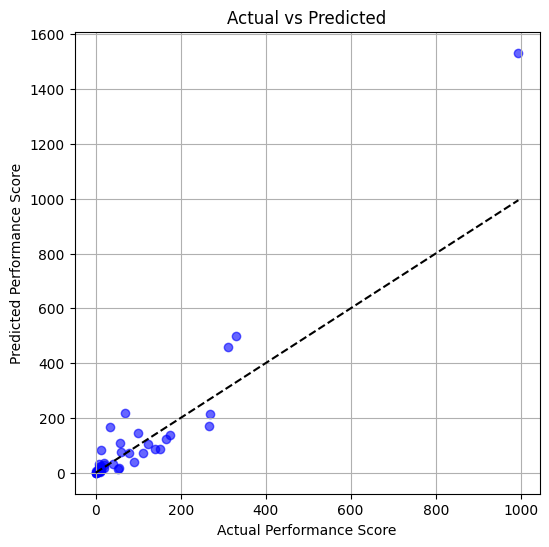

<Figure size 1000x600 with 0 Axes>

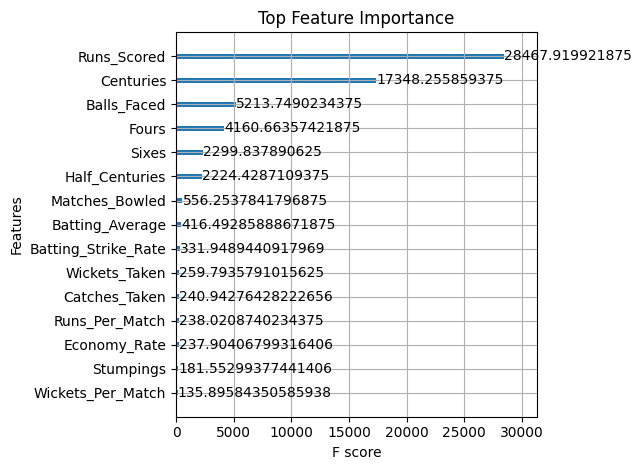

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt
import joblib

# Step 1: Load dataset
print("🔄 Loading historical training data...")
df = pd.read_csv("/content/Final_cricket_data.csv")

# Step 2: Ensure features are numeric
features = [
    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Batted", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", "Catches_Taken", "Stumpings", "Credits"
]

df[features] = df[features].apply(pd.to_numeric, errors='coerce')
df.fillna(0, inplace=True)

# Step 3: Optional - add player role if missing
if 'Player Type' not in df.columns:
    df['Player Type'] = 'ALL'  # fallback if not present

# Step 4: Create new features (feature engineering)
df['Runs_Per_Match'] = df['Runs_Scored'] / (df['Matches_Batted'] + 1)
df['Wickets_Per_Match'] = df['Wickets_Taken'] / (df['Matches_Bowled'] + 1)
df['Total_Matches'] = df['Matches_Batted'] + df['Matches_Bowled']
df['Strike_Efficiency'] = df['Runs_Scored'] / (df['Balls_Faced'] + 1)
df['Consistency_Score'] = (df['Runs_Per_Match'] + df['Wickets_Per_Match']) / 2

# Step 5: Calculate role-based performance score
def role_based_score(row):
    if row['Player Type'] == 'BAT':
        return (
            row['Runs_Scored'] * 0.5 +
            row['Batting_Strike_Rate'] * 0.2 +
            row['Catches_Taken'] * 0.2 +
            row['Consistency_Score'] * 0.1
        )
    elif row['Player Type'] == 'BOWL':
        return (
            row['Wickets_Taken'] * 0.4 +
            row['Bowling_Strike_Rate'] * 0.2 +
            row['Economy_Rate'] * 0.1 +
            row['Catches_Taken'] * 0.1 +
            row['Consistency_Score'] * 0.2
        )
    else:  # ALLROUNDER
        return (
            row['Runs_Scored'] * 0.3 +
            row['Wickets_Taken'] * 0.3 +
            row['Catches_Taken'] * 0.2 +
            row['Consistency_Score'] * 0.2
        )

df['Performance_Score'] = df.apply(role_based_score, axis=1)

# Step 6: Final features for modeling
model_features = features + ['Runs_Per_Match', 'Wickets_Per_Match', 'Total_Matches', 'Strike_Efficiency', 'Consistency_Score']
X = df[model_features]
y = df['Performance_Score']

# Step 7: Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: RandomizedSearchCV for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

print("🔍 Performing hyperparameter tuning...")
random_search = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    param_distributions=param_dist,
    scoring='neg_mean_squared_error',
    n_iter=20,
    cv=3,
    verbose=1,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
model = random_search.best_estimator_

# Step 9: Model Evaluation
# Step 9: Model Evaluation
y_pred = model.predict(X_test)

# Compute RMSE manually
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ Model Evaluation:\nRMSE: {rmse:.2f}\nR² Score: {r2:.2f}")


# Step 10: Save model
joblib.dump(model, "performance_model.pkl")
print("💾 Model saved as player_performance_model.pkl")

# Step 11: Plot Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual Performance Score")
plt.ylabel("Predicted Performance Score")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()

# Step 12: Plot Feature Importance
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=15, importance_type='gain')
plt.title("Top Feature Importance")
plt.tight_layout()
plt.show()


In [ ]:
!pip install --upgrade xgboost

In [ ]:
import xgboost
print("Version:", xgboost.__version__)
print("Path:", xgboost.__file__)


Version: 2.1.4
Path: /usr/local/lib/python3.11/dist-packages/xgboost/__init__.py


Found existing installation: xgboost 3.0.0
Uninstalling xgboost-3.0.0:
  Successfully uninstalled xgboost-3.0.0
  Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached nvidia_nccl_cu12-2.26.2.post1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.0 kB)
ERROR: Operation cancelled by user


In [ ]:
!pip install XGBoost

  Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl (253.9 MB)


In [ ]:
pip install xgboost==1.5.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.5/173.5 MB 3.2 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.0.0
    Uninstalling xgboost-3.0.0:
      Successfully uninstalled xgboost-3.0.0


In [ ]:
pip install xgboost pandas numpy scikit-learn joblib


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt
import joblib

# Load dataset
print("🔄 Loading historical training data...")
df = pd.read_csv("/content/Final_cricket_data.csv")

# Step 2: Ensure features are numeric
features = [
    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled", "Matches_Batted",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls", "Catches_Taken",
    "Stumpings", "Credits"
]

df[features] = df[features].apply(pd.to_numeric, errors='coerce')
df.fillna(0, inplace=True)

# Step 3: Optional - add player role if missing
if 'Player_Type' not in df.columns:
    df['Player_Type'] = 'ALLROUNDER'  # fallback if not present

# Step 4: Feature Engineering
df['Runs_Per_Match'] = df['Runs_Scored'] / (df['Matches_Batted'] + 1)
df['Wickets_Per_Match'] = df['Wickets_Taken'] / (df['Matches_Bowled'] + 1)
df['Total_Matches'] = df['Matches_Batted'] + df['Matches_Bowled']
df['Strike_Efficiency'] = df['Runs_Scored'] / (df['Balls_Faced'] + 1)
df['Consistency_Score'] = (df['Runs_Per_Match'] + df['Wickets_Per_Match']) / 2

# Step 5: Calculate Role-Based Performance Score
def role_based_score(row):
    if row['Player_Type'] == 'BATTER':
        return (
            row['Runs_Scored'] * 0.5 +
            row['Batting_Strike_Rate'] * 0.3+
            row['Catches_Taken'] * 0.2

        )
    elif row['Player_Type'] == 'WK':
        return (
            row['Runs_Scored'] * 0.5 +
            row['Batting_Strike_Rate'] * 0.3+
            row['Catches_Taken'] * 0.2 )

    elif row['Player_Type'] == 'BOWLER':
        return (
            row['Wickets_Taken'] * 0.5 +
            row['Bowling_Strike_Rate'] * 0.2 +
            row['Economy_Rate'] * 0.1 +
            row['Catches_Taken'] * 0.1

        )
    else:  # ALLROUNDER
        return (
            row['Runs_Scored'] * 0.3 +
            row['Wickets_Taken'] * 0.3 +
            row['Catches_Taken'] * 0.2 +
            row['Batting_Strike_Rate'] * 0.2

        )

df['Performance_Score'] = df.apply(role_based_score, axis=1)

# Step 6: Final features for modeling
model_features = features + ['Runs_Per_Match', 'Wickets_Per_Match', 'Total_Matches', 'Strike_Efficiency']
X = df[model_features]
y = df['Performance_Score']

# Step 7: Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: RandomizedSearchCV for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

print("🔍 Performing hyperparameter tuning...")
random_search = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    param_distributions=param_dist,
    scoring='neg_mean_squared_error',
    n_iter=20,
    cv=3,
    verbose=1,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
model = random_search.best_estimator_

# Step 9: Model Evaluation
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ Model Evaluation:\nRMSE: {rmse:.2f}\nR² Score: {r2:.2f}")

# Step 10: Save model
joblib.dump(model, "player_performance_model.pkl")
print("💾 Model saved as player_performance_model.pkl")




🔄 Loading historical training data...
🔍 Performing hyperparameter tuning...


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
import xgboost
import sklearn
!pip uninstall xgboost
!pip install xgboost


print(f"xgboost version: {xgboost.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")


Found existing installation: xgboost 1.5.1
Uninstalling xgboost-1.5.1:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/xgboost-1.5.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/xgboost.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.11/dist-packages/xgboost/*
Proceed (Y/n)? y
  Successfully uninstalled xgboost-1.5.1
  Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl (253.9 MB)
xgboost version: 1.5.1
scikit-learn version: 1.6.1


In [ ]:
!pip install scikit-learn


final

In [2]:
# @title Default title text
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# ✅ Load the dataset
df= pd.read_csv("/content/CricMasters_2.0.csv")

# ✅ Convert numerical columns to float
num_columns = [
    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls","Catches_Taken",
    "Stumpings", "Credits"]
# ✅ Convert columns to numeric (forcing errors='coerce' to handle bad data)
df[num_columns] = df[num_columns].apply(pd.to_numeric, errors="coerce")

# ✅ Fill missing values with 0
df.fillna(0, inplace=True)

# ✅ Select Features and Target

features = [

    "Runs_Scored", "Batting_Average", "Batting_Strike_Rate", "Balls_Faced", "Centuries",
    "Half_Centuries", "Fours", "Sixes", "Matches_Bowled",
    "Wickets_Taken", "Bowling_Average", "Economy_Rate", "Bowling_Strike_Rate",
    "Four_Wicket_Hauls", "Five_Wicket_Hauls","Catches_Taken",
    "Stumpings", "Credits"
]

target = "Fantasy_Points"

X = df[features]
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    enable_categorical=False  # Make sure categorical features are not included
)

xgb_model.fit(X_train, y_train)

# ✅ Make predictions
y_pred = xgb_model.predict(X_test)

# ✅ Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"✅ Model Training Completed! MAE: {mae:.2f}")

# ✅ Save the trained model
import pickle
with open("model1.pkl", "wb") as model_file:
    pickle.dump(xgb_model, model_file)

print("✅ Fantasy Model saved as 'model.pkl'")


✅ Model Training Completed! MAE: 156.01
✅ Fantasy Model saved as 'model.pkl'


In [ ]:
# prompt: accuracy score

from sklearn.metrics import accuracy_score

# Assuming you have a classification problem and need accuracy
# If your problem is regression, accuracy score is not applicable.
# Based on your code, you are training a Regressor (XGBRegressor)
# For regression, metrics like MAE, MSE, RMSE, R^2 are used (which you already have).

# If this was a classification problem:
# Assuming y_test and y_pred are discrete labels or probabilities
# You would need to convert probabilities to class labels for accuracy

# Example for a hypothetical classification scenario:
# You would need a classification model instead of XGBRegressor
# from sklearn.linear_model import LogisticRegression # Example

# If xgb_model was a classifier:
# y_pred_classes = xgb_model.predict(X_test_scaled) # or X_test if not scaled

# Then calculate accuracy:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")


ValueError: continuous is not supported